In [31]:
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [1]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data 
import tensorflow.data as tfd
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array

# Data Visualization
import matplotlib.pyplot as plt

# Model
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import AveragePooling2D
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

# Pretrained Model
from tensorflow.keras.applications import ResNet50

# Callbacks
from keras.callbacks import Callback, ModelCheckpoint

# Model Visualization
from tensorflow.keras.utils import plot_model

# Model Explaination
from tf_explain.core.grad_cam import GradCAM

In [57]:
!pip install --upgrade keras-cv tensorflow

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/650.7 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/650.7 kB ? eta -:--:--
   ---------------------------------------- 650.7/650.7 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/950.8 kB ? eta -:--:--
   --------------------------------- ------ 786.4/950.8 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 950.8/950.8 kB 3.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   -- ------------------------------------- 0.3/5.1 MB ? eta -:--:--
   ---------- ----------------------------- 1.3/5.1 MB 3.7 MB/s eta 0:00:02
   ---------------- ----------------------- 2.1/5.1 MB 3.5 MB/s eta 0:00:01
   -------------------- ------------------- 2.6/5.1 MB 3.4 MB/s eta 0:00:01
   -------------------------- ------------- 3.4/5.1 MB 3.4 MB/s eta 0:00:01
 

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\tfds.exe' -> 'C:\\Python312\\Scripts\\tfds.exe.deleteme'



In [2]:
import tifffile 
direct = "images"
input_image = []
for filename in os.listdir(direct):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        filepath= os.path.join(direct,filename)
        try:
            image = np.array(tifffile.imread(filepath))
            # Convert to float32
            image = tf.cast(image, tf.float32)
            # Standardization
            image = image/255.
            input_image.append(image)
        except Exception as e:
            print(f"Failed to load {filename}: {e}")

In [3]:
import glob  # To find files matching a pattern
import os    # For file path operations and deleting files
from PIL import Image  # To open and process images
import numpy as np  # To convert images to NumPy arrays
import re
# Path to the directory containing images
directory = "labels"
segmentation_labels = []
## this is used for the numerical ordering in the files name not by the string ordering 
def natural_key(file_name):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', file_name)]

image_files = sorted(glob.glob(os.path.join(directory, '*.[pjJ][npN]*[gG]*')), key=natural_key)
# Load and process each image
for file_path in image_files:
    image = Image.open(file_path)
    segmentation_labels.append(np.array(image))
    print(file_path)

labels\0.png
labels\1.png
labels\2.png
labels\3.png
labels\4.png
labels\5.png
labels\6.png
labels\7.png
labels\8.png
labels\9.png
labels\10.png
labels\11.png
labels\12.png
labels\13.png
labels\14.png
labels\15.png
labels\16.png
labels\17.png
labels\18.png
labels\19.png
labels\20.png
labels\21.png
labels\22.png
labels\23.png
labels\24.png
labels\25.png
labels\26.png
labels\27.png
labels\28.png
labels\29.png
labels\30.png
labels\31.png
labels\32.png
labels\33.png
labels\34.png
labels\35.png
labels\36.png
labels\37.png
labels\38.png
labels\39.png
labels\40.png
labels\41.png
labels\42.png
labels\43.png
labels\44.png
labels\45.png
labels\46.png
labels\47.png
labels\48.png
labels\49.png
labels\50.png
labels\51.png
labels\52.png
labels\53.png
labels\54.png
labels\55.png
labels\56.png
labels\57.png
labels\58.png
labels\59.png
labels\60.png
labels\61.png
labels\62.png
labels\63.png
labels\64.png
labels\65.png
labels\66.png
labels\67.png
labels\68.png
labels\69.png
labels\70.png
labels\71.png
la

In [4]:
print("input images:", len(input_image))
print("segmentation labels:",len(segmentation_labels))
print("shape of images:", input_image[0].shape)
print("shape of labels:", segmentation_labels[0].shape)

input images: 306
segmentation labels: 306
shape of images: (128, 128, 12)
shape of labels: (128, 128)


Datasets Preparation

In [5]:
import random
data_images = input_image
data_masks = segmentation_labels

# shuffle the data before data preparation
zipped_data = list(zip(data_images,data_masks))
random.shuffle(zipped_data)
data_images,data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [6]:
data_images

[<tf.Tensor: shape=(128, 128, 12), dtype=float32, numpy=
 array([[[0.9137255 , 0.7137255 , 1.5882353 , ..., 1.4156862 ,
          0.03921569, 0.        ],
         [0.9019608 , 0.7137255 , 1.6745098 , ..., 1.4117647 ,
          0.11764706, 0.        ],
         [0.9019608 , 0.68235296, 1.6823529 , ..., 1.4156862 ,
          0.03921569, 0.        ],
         ...,
         [1.2823529 , 1.172549  , 2.5411766 , ..., 1.572549  ,
          0.11764706, 0.        ],
         [1.2823529 , 1.2352941 , 2.5411766 , ..., 1.5764706 ,
          0.11764706, 0.        ],
         [1.2745098 , 1.3372549 , 2.545098  , ..., 1.5764706 ,
          0.11764706, 0.        ]],
 
        [[1.0313725 , 1.1450981 , 2.4196079 , ..., 1.4156862 ,
          0.03921569, 0.        ],
         [1.1686275 , 1.2117647 , 2.4705882 , ..., 1.4117647 ,
          0.11764706, 0.        ],
         [1.1686275 , 0.79607844, 1.6235294 , ..., 1.4156862 ,
          0.03921569, 0.        ],
         ...,
         [1.2862746 , 1.007843

In [40]:
 # Convert To data 
data = tfd.Dataset.from_tensor_slices((input_image, segmentation_labels))
data = data.batch(32, drop_remainder=True)
data = data.shuffle(1000).prefetch(tfd.AUTOTUNE)

In [41]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 12), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128), dtype=tf.uint8, name=None))>

Before Scalling

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_image , val_image , train_labels , val_labels =train_test_split(data_images ,data_masks, test_size=0.2, random_state=0)

In [8]:
print(len(train_image))
print(len(val_image))
print(len(train_labels))
print(len(val_labels))

244
62
244
62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10980392..4.309804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09019608..4.5686274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40392157..4.3490195].


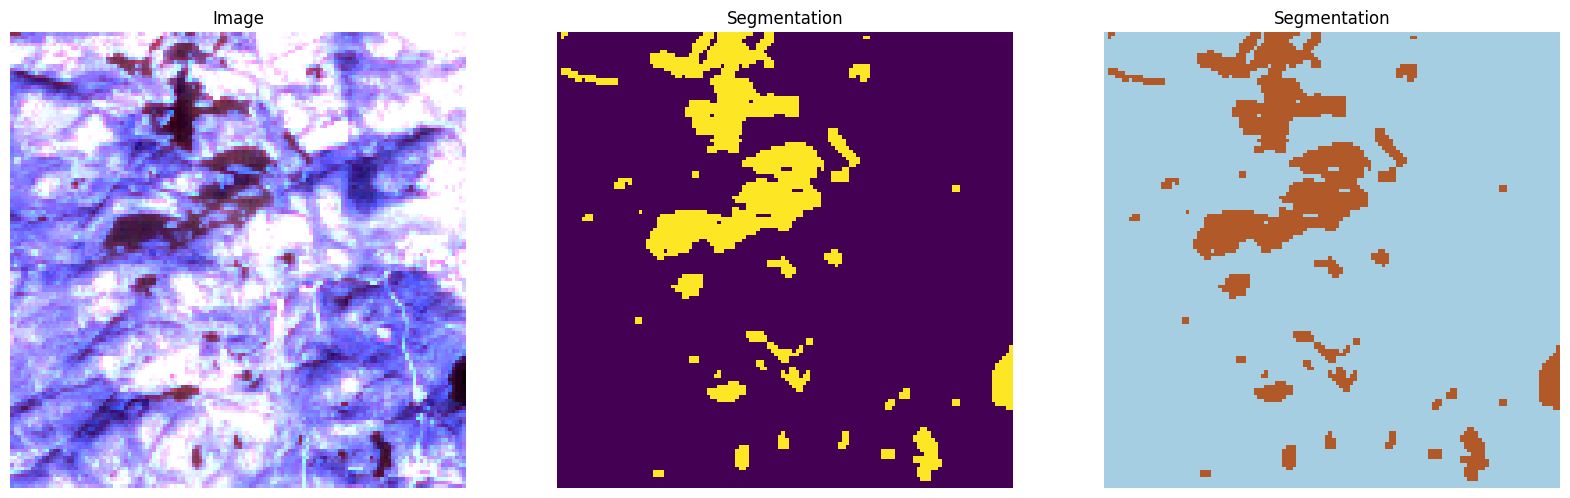

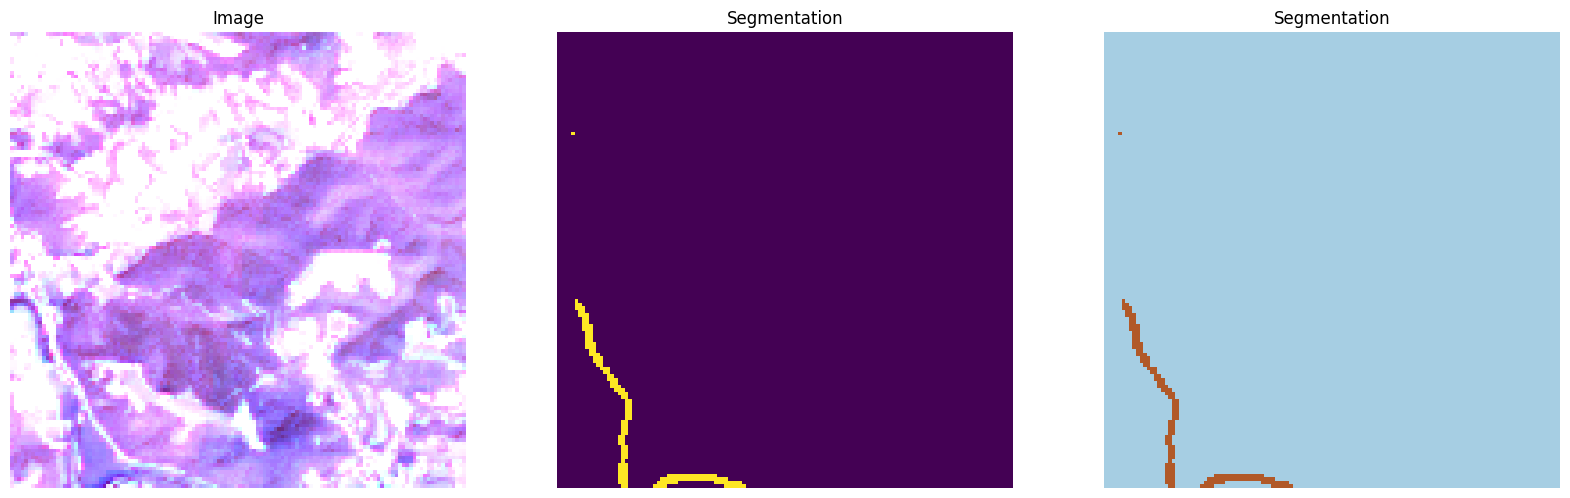

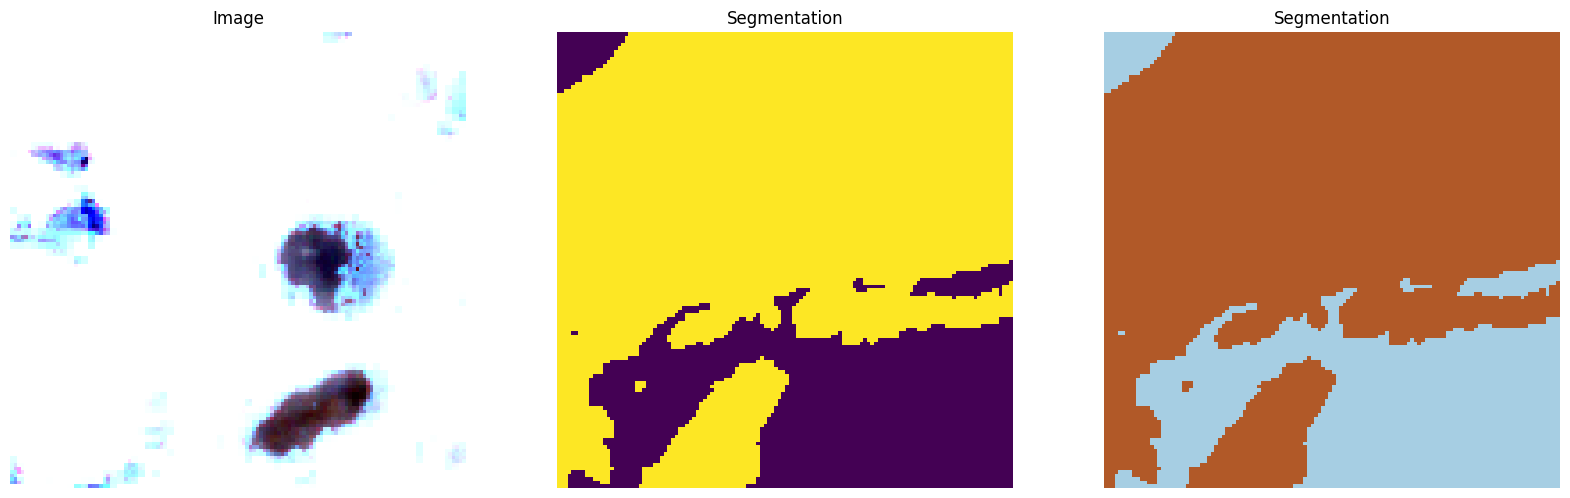

In [9]:
import random
number_of_samples = len(direct)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = input_image[i][:, :, :3]
    mask = segmentation_labels[i]
    #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Segmentation')
    arr[2].axis("off")

In [10]:
train_image[0]

<tf.Tensor: shape=(128, 128, 12), dtype=float32, numpy=
array([[[1.5450981e+00, 1.9215686e+00, 3.2941177e+00, ...,
         5.0980395e-01, 3.9215688e-02, 0.0000000e+00],
        [1.5450981e+00, 1.8705882e+00, 3.3686275e+00, ...,
         5.0980395e-01, 3.9215688e-02, 0.0000000e+00],
        [1.5019608e+00, 1.5176470e+00, 2.5882354e+00, ...,
         5.1764709e-01, 3.9215688e-02, 0.0000000e+00],
        ...,
        [1.9607843e+00, 2.2823529e+00, 3.5450981e+00, ...,
         4.7450981e-01, 1.5686275e-01, 0.0000000e+00],
        [1.9333333e+00, 2.2549019e+00, 3.5098040e+00, ...,
         4.7450981e-01, 1.5686275e-01, 0.0000000e+00],
        [1.9333333e+00, 2.2352941e+00, 3.5490196e+00, ...,
         4.7058824e-01, 1.5686275e-01, 0.0000000e+00]],

       [[1.8901961e+00, 2.4431372e+00, 3.8274510e+00, ...,
         4.8627451e-01, 1.1764706e-01, 0.0000000e+00],
        [1.8901961e+00, 2.1176472e+00, 3.5764706e+00, ...,
         4.9019608e-01, 3.9215688e-02, 0.0000000e+00],
        [1.866666

Data Agumentaion

In [11]:
# train the model
train_image_array = np.array(train_image)
train_labels_array = np.array(train_labels)
val_image_array = np.array(val_image)
val_labels_array =np.array(val_labels)

In [12]:
train_image_array.shape

(244, 128, 128, 12)

In [13]:
import keras_cv
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=0.2 ,value_range=(0,128)),
        keras_cv.layers.RandomContrast(factor=0.2,value_range=(0,128))
    ]
)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import tensorflow as tf

def augment_data(images, labels):
  # Combine images and labels into a single dataset
  dataset = tf.data.Dataset.zip((images, labels))

  # Apply data augmentation to the combined dataset
  dataset = dataset.map(lambda x, y: (augment_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)

  # Shuffle the dataset for better generalization
  dataset = dataset.shuffle(buffer_size=1024, seed=42)

  # Batch the dataset for efficient training
  dataset = dataset.batch(batch_size=32, drop_remainder=True)

  # Prefetch the dataset to improve performance
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

# Assuming input_image and segmentation_labels are lists
train_image_dataset = tf.data.Dataset.from_tensor_slices(train_image_array)
val_image_dataset = tf.data.Dataset.from_tensor_slices(val_image_array)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels_array)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels_array)

# Now you can call your augment_data function
train_dataset = augment_data(train_image_dataset, train_labels_dataset)
val_dataset = augment_data(val_image_dataset, val_labels_dataset)

model

In [49]:
import tensorflow as tf
from tensorflow.keras.applications.deeplab import DeepLabV3
input_shape = (128 ,128, 12)
#model = DeepLabV3(weights='imagenet', input_shape=input_shape)

ModuleNotFoundError: No module named 'tensorflow.keras.applications.deeplab'

DeepLabV3+

In [29]:
class ConvBlock(Layer):
    
    def __init__(self, filters=256, kernel_size=3, dilation_rate=1, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        
        self.net = Sequential([
            Conv2D(filters, kernel_size=kernel_size, padding='same', dilation_rate=dilation_rate, use_bias=False, kernel_initializer='he_normal'),
            BatchNormalization(), 
            ReLU()
        ])
    
    def call(self, X):
        return self.net(X)
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "kernel_size":self.kernel_size,
            "dilation_rate":self.dilation_rate,
        }

In [30]:
def AtrousSpatialPyramidPooling(X):
    B, H, W, C = X.shape
    
    # Image Pooling
    image_pool = AveragePooling2D(pool_size=(H, W), name="ASPP-AvgPool")(X)
    image_pool = ConvBlock(kernel_size=1, name="ASPP-ImagePool-CB")(image_pool)
    image_pool = UpSampling2D(size=(H//image_pool.shape[1], W//image_pool.shape[2]), name="ASPP-ImagePool-UpSample")(image_pool)
    
    # Atrous Oprtations
    conv_1  = ConvBlock(kernel_size=1, dilation_rate=1, name="ASPP-CB-1")(X)
    conv_6  = ConvBlock(kernel_size=3, dilation_rate=6, name="ASPP-CB-6")(X)
    conv_12 = ConvBlock(kernel_size=3, dilation_rate=12, name="ASPP-CB-12")(X)
    conv_18 = ConvBlock(kernel_size=3, dilation_rate=18, name="ASPP-CB-18")(X)
    
    # Combine All
    
    
    combined = Concatenate(name="ASPP-Combine")([image_pool, conv_1, conv_6, conv_12, conv_18])
    processed = ConvBlock(kernel_size=1, name="ASPP-Net")(combined)
    
    # Final Output
    return processed

In [19]:
# PARAM
LR = 1e-3
IMAGE_SIZE = 128

# Input
InputL = Input(shape=(32,IMAGE_SIZE, IMAGE_SIZE, 12), name="InputLayer")

# Base Mode
resnet50 = ResNet50(include_top=False, weights='imagenet', input_tensor=InputL)

# ASPP Phase
DCNN = resnet50.get_layer('conv4_block6_2_relu').output
ASPP = AtrousSpatialPyramidPooling(DCNN)
ASPP = UpSampling2D(size=(IMAGE_SIZE//4//ASPP.shape[1], IMAGE_SIZE//4//ASPP.shape[2]), name="AtrousSpatial")(ASPP)

# LLF Phase
LLF = resnet50.get_layer('conv2_block3_2_relu').output
LLF = ConvBlock(filters=48, kernel_size=1, name="LLF-ConvBlock")(LLF)

# Combined
combined = Concatenate(axis=-1, name="Combine-LLF-ASPP")([ASPP, LLF])
features = ConvBlock(name="Top-ConvBlock-1")(combined)
features = ConvBlock(name="Top-ConvBlock-2")(features)
upsample = UpSampling2D(size=(IMAGE_SIZE//features.shape[1], IMAGE_SIZE//features.shape[1]), interpolation='bilinear', name="Top-UpSample")(features)

# Output Mask
PredMask = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='sigmoid', use_bias=False, name="OutputMask")(upsample)

# DeelLabV3+ Model
model = Model(InputL, PredMask, name="DeepLabV3-Plus")
model.summary()

ValueError: Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, 32, 128, 128, 12)

In [53]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 12), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128), dtype=tf.uint8, name=None))>

In [61]:
train_dataset_array =np.array(train_dataset)
train_dataset_array

array(<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 12), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128), dtype=tf.uint8, name=None))>,
      dtype=object)

Try another Model

-----------------------------------------------------------------------------------------------

Another model 

In [22]:

from keras import layers
from keras import ops

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io
# PARAM
LR = 1e-3
IMAGE_SIZE = 128
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [23]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 12))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c

 Total params: 11,852,353 (45.21 MB)

 Trainable params: 11,819,617 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [24]:
model.compile(optimizer="adam",loss='binary_crossentropy', metrics=['accuracy'])

Before agumentaion

In [25]:
history = model.fit(train_image_array, train_labels_array , validation_data=(val_image_array, val_labels_array), epochs=5)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.5851 - loss: 4.8837 - val_accuracy: 0.2446 - val_loss: 12.0425
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6818 - loss: 4.0517 - val_accuracy: 0.2787 - val_loss: 11.5006
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6652 - loss: 1.8391 - val_accuracy: 0.7554 - val_loss: 3.9429
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.7018 - loss: 0.9131 - val_accuracy: 0.7554 - val_loss: 3.9429
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.7439 - loss: 0.7811 - val_accuracy: 0.7554 - val_loss: 3.9429


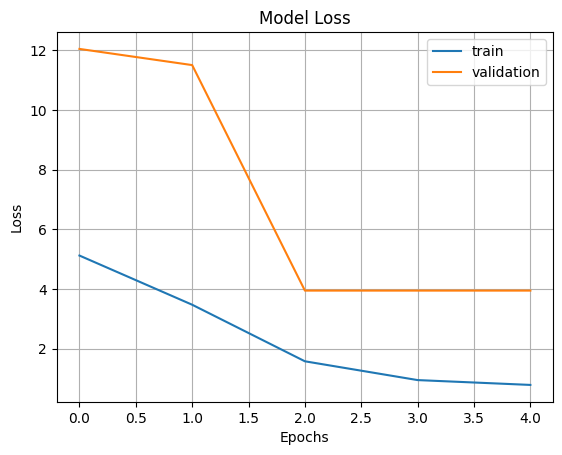

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

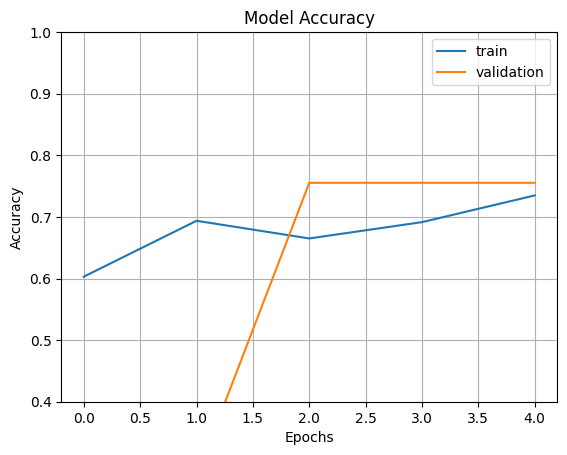

In [27]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [28]:
prediction = model.predict(val_image_array)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10980392..4.309804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09019608..4.5686274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40392157..4.3490195].


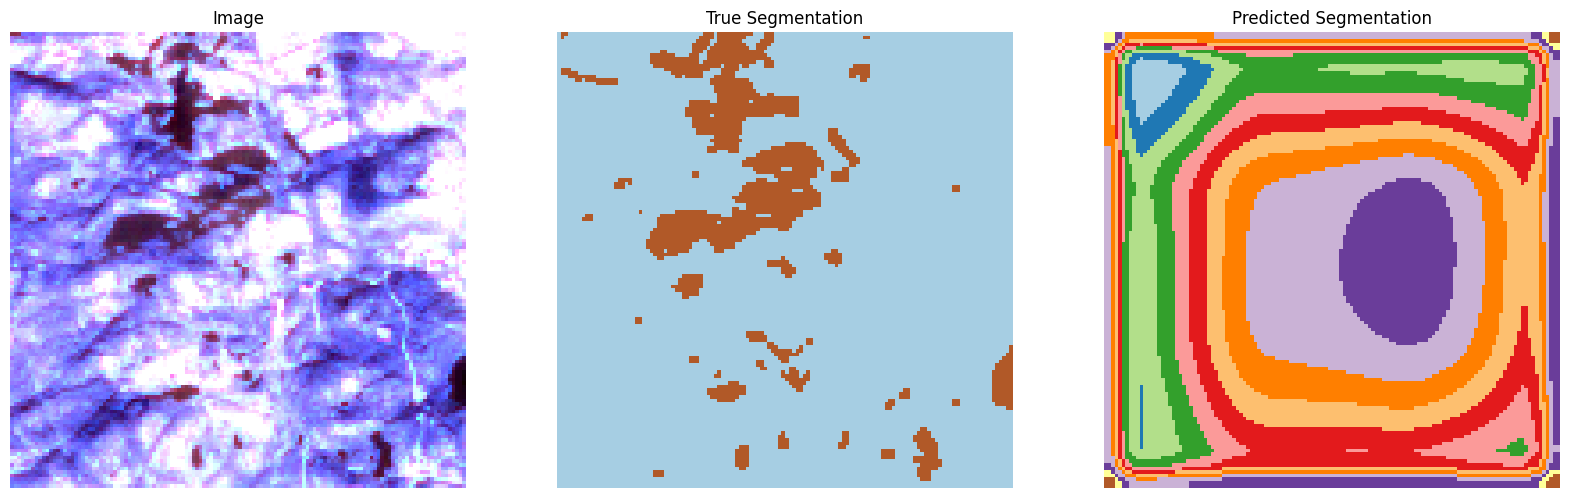

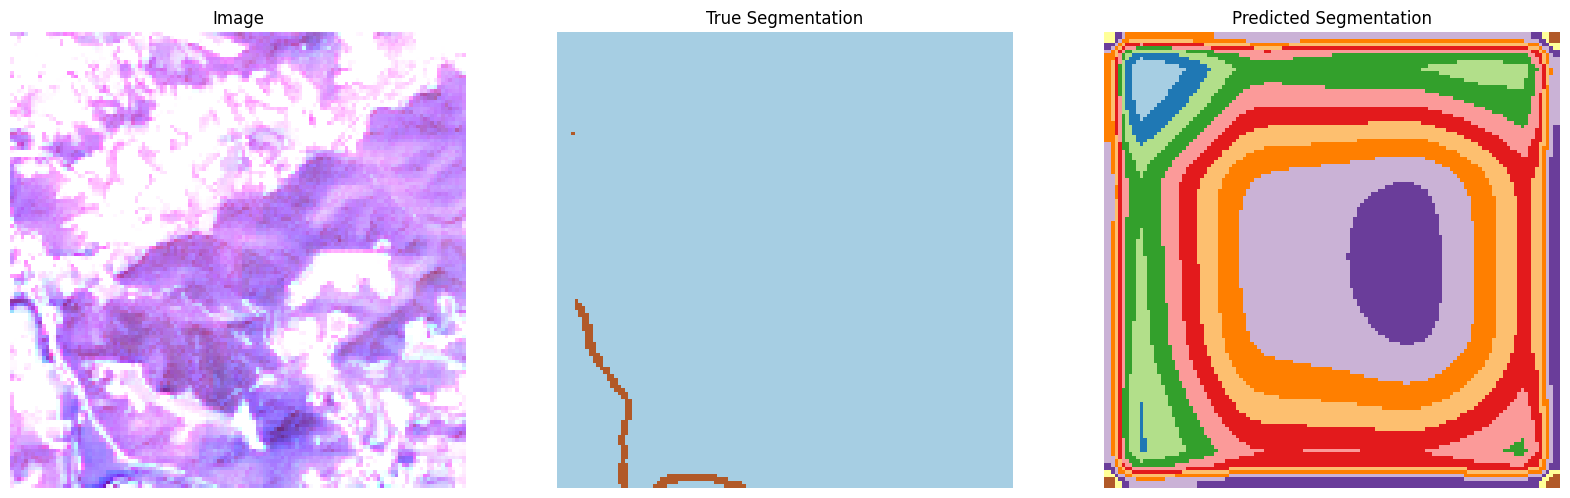

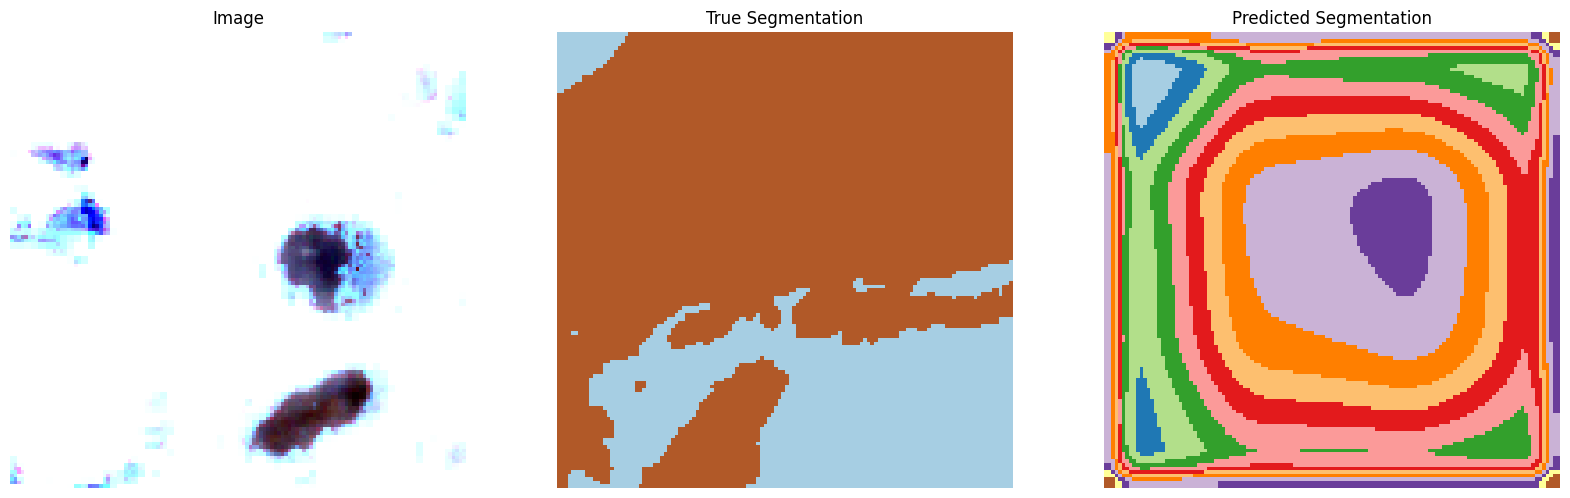

In [30]:
import random
import matplotlib.pyplot as plt

number_of_samples = len(direct)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = input_image[i][:, :, :3]
    true_mask = segmentation_labels[i]  # Load the true segmentation mask
    predicted_mask = prediction[i]  # Your existing predicted segmentation mask

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")

    arr[1].imshow(true_mask, cmap='Paired')  # Display true segmentation
    arr[1].set_title('True Segmentation')
    arr[1].axis("off")

    arr[2].imshow(predicted_mask, cmap='Paired')  # Display predicted segmentation
    arr[2].set_title('Predicted Segmentation')
    arr[2].axis("off")

plt.show()  # Show all three panels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10980392..4.309804].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09019608..4.5686274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40392157..4.3490195].


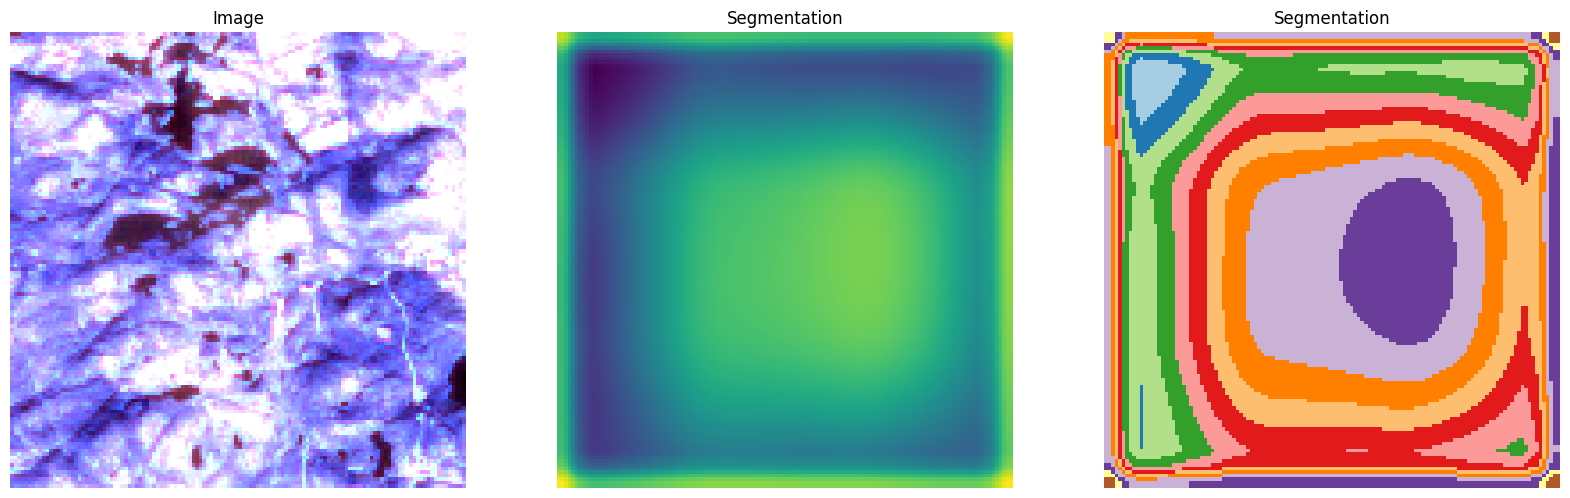

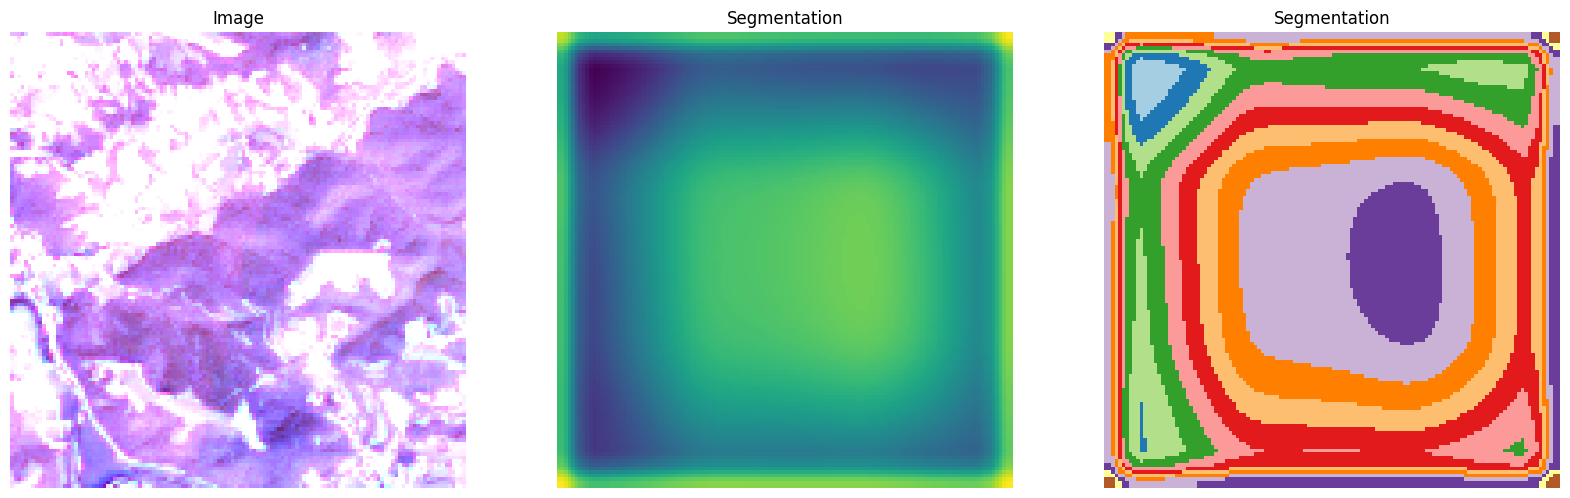

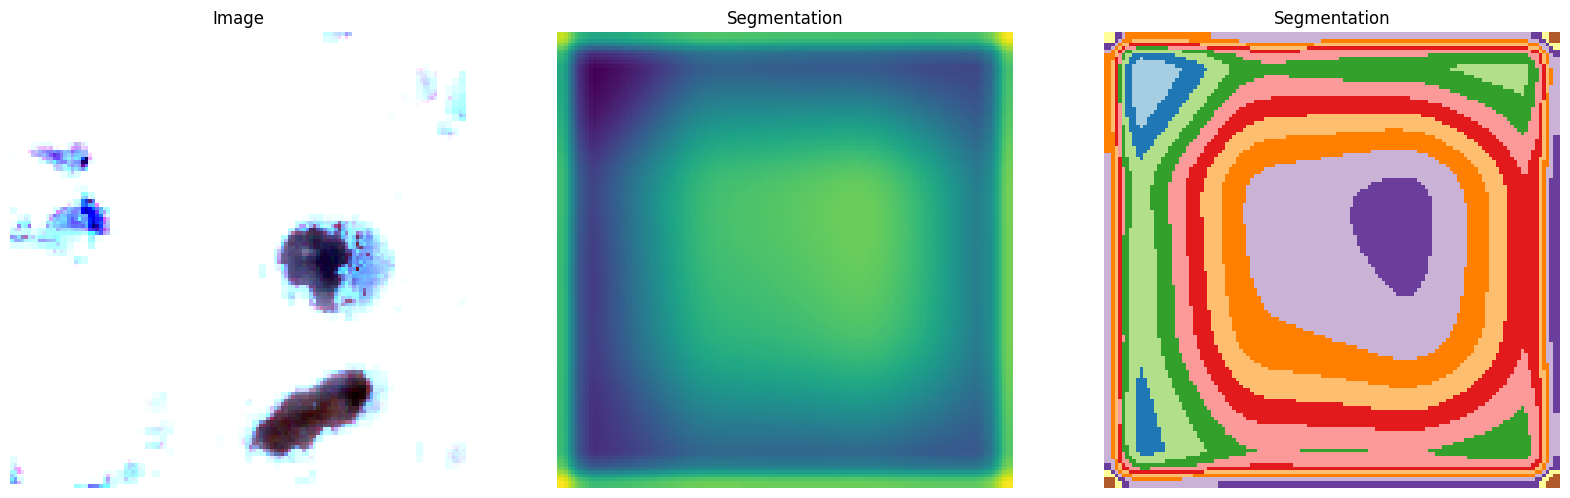

In [34]:
import random
number_of_samples = len(direct)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = input_image[i][:, :, :3]
    mask = prediction[i]
    #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")    
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Segmentation')
    arr[2].axis("off")